## Feature Selection

### <a href=#s2>Baseline</a>
### <a href=#s3>Correlations, basic OLS</a>
### <a href=#s4> Lasso Regularization</a>

In [1]:
import pandas as pd
import re
import numpy as np
import datetime as dt

import pipeline as p
import fitting as f
%load_ext autoreload
%autoreload 2

from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
# %reload_ext autoreload

In [2]:
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, make_scorer
scoring = {'R2': make_scorer(r2_score), 'MSE': make_scorer(mean_squared_error, greater_is_better=False)}

In [3]:
X_train = p.open_pkl('Data/X_train.pkl')
y_train  = p.open_pkl('Data/y_train.pkl')

train_df = X_train.join(y_train)
target = 'point_diff'

In [9]:
drop_df = train_df.dropna()

In [10]:
len(train_df), len(dum_df)

(2394, 2233)

### 2. Baseline <a name=s2 />
We know that FivethrityEight's Elo model includes only game Location, and Elo for Team & Opponent entering the week. We'll use this as our baseline

In [12]:
simple_cols = ['elo1_pre','elo2_pre','Location']

In [13]:
fit = f.simple_OLS(train_df, simple_cols, target)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             point_diff   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     127.2
Date:                Sun, 06 Jan 2019   Prob (F-statistic):           1.94e-76
Time:                        13:50:31   Log-Likelihood:                -9673.8
No. Observations:                2394   AIC:                         1.936e+04
Df Residuals:                    2390   BIC:                         1.938e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.5278      5.800     -1.298      0.194     -18.900       3.845
elo1_pre       0.0435      0.003     15.465      0.000       0.038       0.049
elo2_pre      -0.0368      0.003    -12.883      0.000      -0.042      -0.031
Location       5.5119      4.376      1.259      0.208      -3.070      14.094
==============================================================================
Omnibus:                        9.648   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               12.076
Skew:                           0.044   Prob(JB):                      0.00239
Kurtosis:                       3.337   Cond. No.                     4.40e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

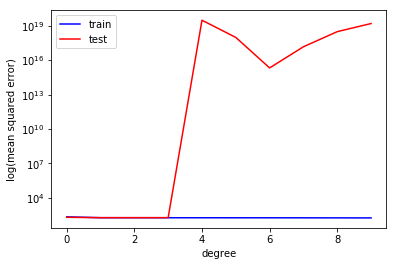

In [18]:
f.pick_degrees(train_df, simple_cols, target, max_deg=10)

In [20]:
f.assess_model_poly(train_df, simple_cols, target, 3)

R2: [0.1391764181742392, 0.10939677076437315, 0.10165485693416199, 0.15691001145904548, 0.14836121236309063]
MSE: [182.8893068496541, 187.90142494291965, 206.31428204292428, 184.27441628087618, 192.19252967941335]


[0.1310998539389821, 190.71439195915752]

### 2. Simple OLS, P-values  <a name=s2 />

In [14]:
drop_cols = ['score1', 'score2', 'elo_delta', 'Date', 'OT', 'Season','Date', 'point_diff']
all_cols = [x for x in train_df.columns if x not in drop_cols]
num_cols = [x for x in all_cols if train_df.dtypes[x] != 'O']

In [54]:
fit2a = f.simple_OLS(train_df, num_cols, target)
fit2a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             point_diff   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     7.695
Date:                Sun, 06 Jan 2019   Prob (F-statistic):           1.46e-52
Time:                        12:32:26   Log-Likelihood:                -8253.5
No. Observations:                2053   AIC:                         1.662e+04
Df Residuals:                    1996   BIC:                         1.694e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -20.2839     21.025     -0.965      0.335     -61.517      20.949
neutral              2.6260      3.646      0.720      0.471      -4.525       9.777
playoff             -0.5911      1.916     -0.308      0.758      -4.349       3.167
elo1_pre             0.0141      0.021      0.657      0.511      -0.028       0.056
elo2_pre            -0.0250      0.022     -1.153      0.249      -0.067       0.017
elo_prob1           -6.1159     13.301     -0.460      0.646     -32.202      19.970
elo_prob2          -14.1680     13.383     -1.059      0.290     -40.415      12.079
Location             5.7628      5.722      1.007      0.314      -5.460      16.985
Week                 0.1038      0.210      0.495      0.620      -0.307       0.515
Losses1              0.0276      0.302      0.091      0.927      -0.565       0.621
FirstD_SA1          -0.2463      0.451     -0.546      0.585      -1.130       0.638
PassY_SA1           -0.6273      1.154     -0.544      0.587      -2.889       1.635
PtsOpp_SA1          -0.4045      0.103     -3.942      0.000      -0.606      -0.203
PtsTm_SA1            0.2202      0.175      1.260      0.208      -0.122       0.563
RushY_SA1           -0.6178      1.153     -0.536      0.592      -2.879       1.643
TO_SA1               0.2606      0.747      0.349      0.727      -1.205       1.726
DefTO_SA1           -0.3219      0.631     -0.510      0.610      -1.560       0.916
TotY_SA1             0.6369      1.153      0.552      0.581      -1.624       2.898
RushAtt_SA1          0.3071      0.321      0.956      0.339      -0.323       0.937
RushTDs_SA1         -0.5515      1.377     -0.401      0.689      -3.252       2.149
PassCmp_SA1         -0.2083      0.996     -0.209      0.834      -2.161       1.744
PassAtt_SA1          0.5517      0.621      0.888      0.375      -0.666       1.770
PassTDs_SA1         -0.2799      1.968     -0.142      0.887      -4.140       3.580
INT_SA1              0.2029      2.004      0.101      0.919      -3.728       4.134
SacksO_SA1           0.6951      0.527      1.319      0.187      -0.339       1.729
Fumbles_SA1         -1.2371      0.670     -1.846      0.065      -2.551       0.077
Penalies_SA1         1.2532      0.504      2.486      0.013       0.265       2.242
PenY_SA1            -0.1016      0.054     -1.877      0.061      -0.208       0.005
ThirdDConv_SA1       0.6341      0.622      1.020      0.308      -0.586       1.854
ThirdDAtt_SA1       -1.2798      0.861     -1.486      0.138      -2.969       0.410
FourthDAtt_SA1       0.3620      0.821      0.441      0.659      -1.249       1.973
PassCompPct_SA1      0.0816      0.402      0.203      0.839      -0.706       0.870
PassRating_SA1       0.0167      0.133      0.125      0.900      -0.245       0.278
TimePossMins_SA1    -0.

In [60]:
# this took too long
# f.pick_degrees(drop_df, num_cols, target, max_deg=6)

#### Get p-values. Select features whose p-values are less than 0.1. Run through Simple OLS

In [62]:
x_cols_02 = f.get_vars_low_pvals(fit2a, pval=0.3)

In [63]:
x_cols_02

['elo2_pre',
 'elo_prob2',
 'PtsOpp_SA1',
 'PtsTm_SA1',
 'SacksO_SA1',
 'Fumbles_SA1',
 'Penalies_SA1',
 'PenY_SA1',
 'ThirdDAtt_SA1',
 'TimePossMins_SA1',
 'PassCmp_SA2',
 'PassAtt_SA2',
 'SacksO_SA2',
 'ThirdDConv_SA2',
 'ThirdDAtt_SA2',
 'FourthDAtt_SA2',
 'PassCompPct_SA2']

In [64]:
fit2b = f.simple_OLS(train_df, x_cols_02, target)
fit2b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             point_diff   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     23.44
Date:                Sun, 06 Jan 2019   Prob (F-statistic):           1.47e-67
Time:                        12:43:48   Log-Likelihood:                -8780.0
No. Observations:                2180   AIC:                         1.760e+04
Df Residuals:                    2162   BIC:                         1.770e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -13.7590     18.169     -0.757      0.449     -49.390      21.872
elo2_pre            -0.0064      0.005     -1.205      0.228      -0.017       0.004
elo_prob2          -24.6556      3.433     -7.182      0.000     -31.388     -17.923
PtsOpp_SA1          -0.1858      0.072     -2.577      0.010      -0.327      -0.044
PtsTm_SA1            0.1905      0.074      2.574      0.010       0.045       0.336
SacksO_SA1           0.0196      0.366      0.054      0.957      -0.698       0.737
Fumbles_SA1         -0.5964      0.536     -1.112      0.266      -1.648       0.455
Penalies_SA1         0.7518      0.443      1.699      0.090      -0.116       1.620
PenY_SA1            -0.0565      0.047     -1.212      0.226      -0.148       0.035
ThirdDAtt_SA1       -0.3639      0.264     -1.381      0.167      -0.881       0.153
TimePossMins_SA1     0.0863      0.158      0.548      0.584      -0.223       0.396
PassCmp_SA2         -1.5183      0.760     -1.998      0.046      -3.009      -0.028
PassAtt_SA2          1.0083      0.483      2.086      0.037       0.060       1.956
SacksO_SA2          -0.5686      0.356     -1.599      0.110      -1.266       0.129
ThirdDConv_SA2      -1.0481      0.417     -2.515      0.012      -1.865      -0.231
ThirdDAtt_SA2        1.0087      0.376      2.684      0.007       0.272       1.746
FourthDAtt_SA2      -2.4717      0.682     -3.626      0.000      -3.809      -1.135
PassCompPct_SA2      0.4979      0.256      1.945      0.052      -0.004       1.000
==============================================================================
Omnibus:                        6.446   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                7.609
Skew:                           0.037   Prob(JB):                       0.0223
Kurtosis:                       3.280   Cond. No.                     9.44e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

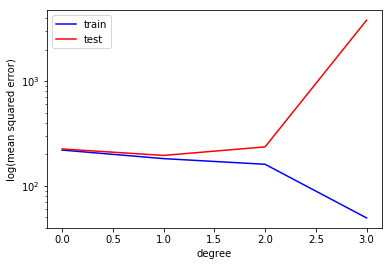

In [66]:
f.pick_degrees(drop_df, x_cols_02, target, max_deg=4)

In [77]:
model = make_pipeline(PolynomialFeatures(2), StandardScaler(), LinearRegression())

In [87]:
cross_validate(model, drop_df[x_cols_02], drop_df[target], cv=5)

{'fit_time': array([0.0261941 , 0.02080607, 0.02361417, 0.03113914, 0.01935482]),
 'score_time': array([0.0042479 , 0.00415802, 0.00434113, 0.00471377, 0.00299811]),
 'test_score': array([ 0.02540411,  0.05521943, -0.00917756,  0.12491351,  0.02072081]),
 'train_score': array([0.25714685, 0.24831231, 0.26684721, 0.23732483, 0.25235977])}

In [98]:
cross_validate(model, drop_df[x_cols_02], drop_df[target], cv=5, scoring=scoring)

{'fit_time': array([0.02418375, 0.02247405, 0.02764606, 0.02294016, 0.01614213]),
 'score_time': array([0.00540423, 0.00820184, 0.00975585, 0.00494504, 0.00566864]),
 'test_R2': array([ 0.02540411,  0.05521943, -0.00917756,  0.12491351,  0.02072081]),
 'train_R2': array([0.25714685, 0.24831231, 0.26684721, 0.23732483, 0.25235977]),
 'test_MSE': array([-205.81108224, -201.82975244, -235.63837476, -195.74643201,
        -217.24620784]),
 'train_MSE': array([-165.87238299, -167.46209341, -159.6939893 , -167.97473742,
        -164.93841978])}

### 3. Correlations. Simple OLS 
<a name=s3 />

In [99]:
dfc = train_df.corr()

In [100]:
dfc.head()

,neutral,playoff,elo1_pre,elo2_pre,elo_prob1,elo_prob2,score1,score2,elo_delta,Location,...,Fumbles_SA2,Penalies_SA2,PenY_SA2,ThirdDConv_SA2,ThirdDAtt_SA2,FourthDAtt_SA2,PassCompPct_SA2,PassRating_SA2,TimePossMins_SA2,point_diff
neutral,1.000000,0.163384,0.042063,0.035211,-0.048643,0.048643,0.036028,-0.011074,0.046575,0.574923,...,-0.009652,0.004452,0.007085,0.002381,-0.008463,0.022405,0.012401,-0.001855,-0.006728,0.032840
playoff,0.163384,1.000000,0.263349,0.232668,0.024405,-0.024405,0.043957,0.015035,0.020985,-0.012274,...,-0.053064,-0.054910,-0.039600,0.044052,-0.000052,-0.021463,0.008864,0.062595,0.067479,0.020771
elo1_pre,0.042063,0.263349,1.000000,0.078979,0.679078,-0.679078,0.253864,-0.143856,0.015556,0.022432,...,-0.021965,0.000210,-0.002406,0.012896,0.000564,0.023232,-0.004076,0.006638,0.021598,0.275893
elo2_pre,0.035211,0.232668,0.078979,1.000000,-0.668180,0.668180,-0.104216,0.223466,0.029954,-0.067223,...,-0.255799,-0.099035,-0.058918,0.294676,-0.125691,-0.252669,0.422980,0.528614,0.368514,-0.224393
elo_prob1,-0.048643,0.024405,0.679078,-0.668180,1.000000,-1.000000,0.262944,-0.266919,-0.014642,0.032511,...,0.170818,0.074740,0.042551,-0.204143,0.090710,0.198938,-0.306649,-0.378121,-0.247896,0.365467


In [ ]:
plt.plot(df)

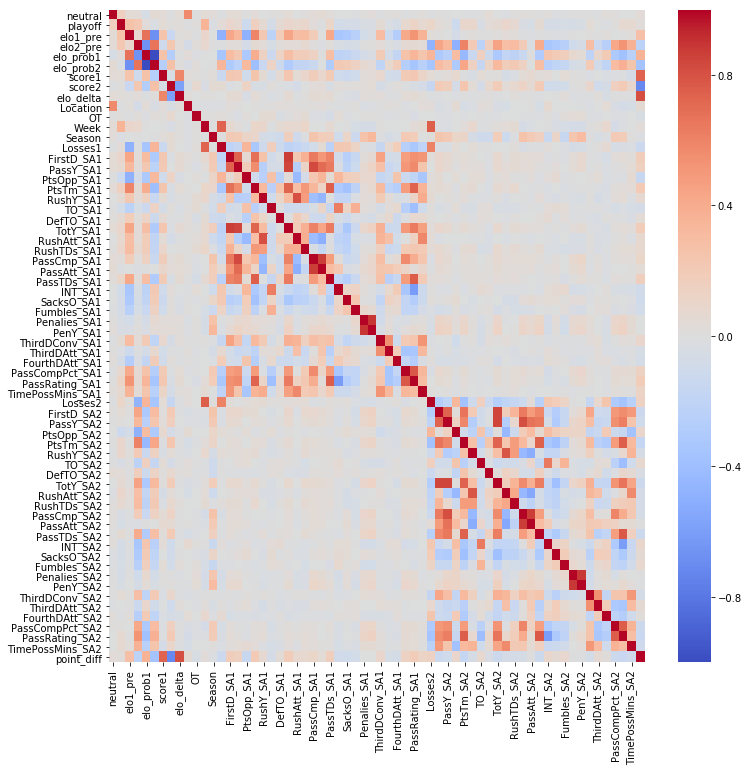

In [101]:
plt.figure(figsize=(12,12))
sns.heatmap(dfc, cmap='coolwarm')

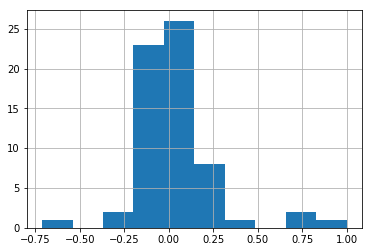

In [102]:
dfc[target].hist()

Most are ~0. But some aren't

In [103]:
corr_cols = list(dfc.loc[(abs(dfc[target]) > 0.1) & (dfc[target] < 1)][target].index)

In [104]:
corr_cols

['elo1_pre',
 'elo2_pre',
 'elo_prob1',
 'elo_prob2',
 'score1',
 'score2',
 'elo_delta',
 'Losses1',
 'FirstD_SA1',
 'PassY_SA1',
 'PtsOpp_SA1',
 'PtsTm_SA1',
 'TotY_SA1',
 'PassCmp_SA1',
 'PassTDs_SA1',
 'SacksO_SA1',
 'PassCompPct_SA1',
 'PassRating_SA1',
 'TimePossMins_SA1',
 'Losses2',
 'FirstD_SA2',
 'PtsTm_SA2',
 'TotY_SA2',
 'PassTDs_SA2',
 'PassCompPct_SA2',
 'PassRating_SA2',
 'TimePossMins_SA2']

In [105]:
drop_cols_02 = ['score1','score2','elo_delta']

In [106]:
corr_cols = [x for x in corr_cols if x not in drop_cols_02]

In [107]:
fit3 = f.simple_OLS(train_df, corr_cols, target)
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             point_diff   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     17.00
Date:                Sun, 06 Jan 2019   Prob (F-statistic):           1.76e-62
Time:                        13:08:55   Log-Likelihood:                -8782.7
No. Observations:                2180   AIC:                         1.761e+04
Df Residuals:                    2156   BIC:                         1.775e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.9417      7.223      1.238      0.216      -5.223      23.106
elo1_pre             0.0339      0.019      1.827      0.068      -0.002       0.070
elo2_pre            -0.0387      0.019     -2.076      0.038      -0.075      -0.002
elo_prob1            3.4401      7.656      0.449      0.653     -11.573      18.454
elo_prob2            5.5015      8.350      0.659      0.510     -10.874      21.877
Losses1              0.1061      0.211      0.503      0.615      -0.308       0.520
FirstD_SA1           0.0032      0.249      0.013      0.990      -0.486       0.492
PassY_SA1           -0.0018      0.021     -0.086      0.932      -0.043       0.040
PtsOpp_SA1          -0.2809      0.084     -3.332      0.001      -0.446      -0.116
PtsTm_SA1            0.0327      0.112      0.292      0.771      -0.187       0.252
TotY_SA1             0.0293      0.021      1.426      0.154      -0.011       0.070
PassCmp_SA1          0.1060      0.217      0.488      0.626      -0.320       0.532
PassTDs_SA1          0.8351      0.982      0.851      0.395      -1.090       2.760
SacksO_SA1           0.1663      0.372      0.447      0.655      -0.564       0.896
PassCompPct_SA1      0.0264      0.121      0.218      0.828      -0.211       0.264
PassRating_SA1      -0.0191      0.054     -0.356      0.722      -0.124       0.086
TimePossMins_SA1    -0.2358      0.178     -1.321      0.187      -0.586       0.114
Losses2             -0.0531      0.207     -0.256      0.798      -0.460       0.353
FirstD_SA2          -0.1729      0.213     -0.813      0.416      -0.590       0.244
PtsTm_SA2            0.0319      0.104      0.306      0.760      -0.173       0.236
TotY_SA2             0.0094      0.013      0.710      0.478      -0.017       0.035
PassTDs_SA2         -0.6302      0.852     -0.740      0.460      -2.301       1.041
PassCompPct_SA2     -0.0068      0.091     -0.076      0.940      -0.185       0.171
PassRating_SA2      -0.0086      0.045     -0.190      0.849      -0.097       0.080
TimePossMins_SA2    -0.0891      0.160     -0.558      0.577      -0.402       0.224
==============================================================================
Omnibus:                        9.375   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               11.660
Skew:                           0.052   Prob(JB):                      0.00294
Kurtosis:                       3.343   Cond. No.                     2.18e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.25e-29. This might indicate that there are
strong multicollinearity problems or that the desi

In [111]:
cross_validate(model, drop_df[corr_cols], drop_df[target], cv=5, scoring=scoring)

{'fit_time': array([0.05915689, 0.04078007, 0.03825521, 0.0394218 , 0.03854108]),
 'score_time': array([0.01808405, 0.00813174, 0.00827289, 0.00799298, 0.00793815]),
 'test_R2': array([-0.21947398, -0.22459094, -0.14736946,  0.04421348, -0.0941111 ]),
 'train_R2': array([0.31524401, 0.2767686 , 0.32623331, 0.29411646, 0.30372556]),
 'test_MSE': array([-257.52341278, -261.60454075, -267.90555655, -213.79806826,
        -242.72086182]),
 'train_MSE': array([-152.8998122 , -161.12255873, -146.75861892, -155.46671333,
        -153.60650896])}

### 4. Lasso Regularization to choose features <a name=s4 />

In [119]:
np.sum(pd.isna(drop_df[num_cols]))

neutral             0
playoff             0
elo1_pre            0
elo2_pre            0
elo_prob1           0
elo_prob2           0
Location            0
Week                0
Losses1             0
FirstD_SA1          0
PassY_SA1           0
PtsOpp_SA1          0
PtsTm_SA1           0
RushY_SA1           0
TO_SA1              0
DefTO_SA1           0
TotY_SA1            0
RushAtt_SA1         0
RushTDs_SA1         0
PassCmp_SA1         0
PassAtt_SA1         0
PassTDs_SA1         0
INT_SA1             0
SacksO_SA1          0
Fumbles_SA1         0
Penalies_SA1        0
PenY_SA1            0
ThirdDConv_SA1      0
ThirdDAtt_SA1       0
FourthDAtt_SA1      0
PassCompPct_SA1     0
PassRating_SA1      0
TimePossMins_SA1    0
Losses2             0
FirstD_SA2          0
PassY_SA2           0
PtsOpp_SA2          0
PtsTm_SA2           0
RushY_SA2           0
TO_SA2              0
DefTO_SA2           0
TotY_SA2            0
RushAtt_SA2         0
RushTDs_SA2         0
PassCmp_SA2         0
PassAtt_SA

In [70]:
# model = make_pipeline(PolynomialFeatures(2), StandardScaler(), LassoCV(cv=5))
model = make_pipeline(StandardScaler(), LassoCV(cv=5))
results01 = cross_validate(model, drop_df[num_cols], drop_df[target], cv=5, scoring=scoring, return_estimator=True)

In [90]:
coefs01 = [results01['estimator'][i].get_params()['lassocv'].coef_ for i in range(5)]

coefs01_mean = np.mean(coefs01, axis=0)

idxs01 = np.argwhere(abs(coefs01_mean) > 1e-02)
idxs01 = [x[0] for x in idxs01]
lcv_cols_01 = [num_cols[x] for x in idxs]

alphas01 = [results01['estimator'][i].get_params()['lassocv'].alpha_ for i in range(5)]
alpha01_mean = np.mean(alphas01)

In [91]:
alphas01

[0.4218826952824352,
 0.371158624858281,
 0.4603829196174208,
 0.35305308827507453,
 0.3297324176404206]

In [92]:
alpha01_mean

0.3872419491347264

In [93]:
len(lcv_cols_01)

20

In [94]:
lcv_cols_01

['neutral',
 'elo2_pre',
 'elo_prob1',
 'Location',
 'FirstD_SA1',
 'PassY_SA1',
 'PtsOpp_SA1',
 'PtsTm_SA1',
 'TotY_SA1',
 'PassTDs_SA1',
 'Fumbles_SA1',
 'PassRating_SA1',
 'FirstD_SA2',
 'PtsTm_SA2',
 'TO_SA2',
 'PassAtt_SA2',
 'Fumbles_SA2',
 'PenY_SA2',
 'ThirdDAtt_SA2',
 'FourthDAtt_SA2']

In [63]:
model = make_pipeline(PolynomialFeatures(2), StandardScaler(), LassoCV(cv=5))
# model = make_pipeline(StandardScaler(), LassoCV(cv=5))
results = cross_validate(model, drop_df[num_cols], drop_df[target], cv=5, scoring=scoring, return_estimator=True)

In [88]:
coefs = [results['estimator'][i].get_params()['lassocv'].coef_ for i in range(5)]
coefs_mean = np.mean(coefs01, axis=0)

idxs02 = np.argwhere(abs(coefs01_mean) > 1e-02)
idxs02 = [x[0] for x in idxs02]

feat_names_02 = results['estimator'][1].get_params()['polynomialfeatures'].get_feature_names()
lcv_cols_02 = [feat_names_02[x] for x in idxs]

alphas02 = [results['estimator'][i].get_params()['lassocv'].alpha_ for i in range(5)]
alpha02_mean = np.mean(alphas02)

In [83]:
lcv_cols_02

['1',
 'x2',
 'x3',
 'x5',
 'x8',
 'x9',
 'x10',
 'x11',
 'x15',
 'x20',
 'x23',
 'x30',
 'x33',
 'x36',
 'x38',
 'x44',
 'x48',
 'x50',
 'x52',
 'x53']

No interactions or higher-order terms have "non-zero" coefficients

In [95]:
idxs01

[0, 3, 4, 6, 9, 10, 11, 12, 16, 21, 24, 31, 34, 37, 39, 45, 49, 51, 53, 54]

In [96]:
idxs02

[0, 3, 4, 6, 9, 10, 11, 12, 16, 21, 24, 31, 34, 37, 39, 45, 49, 51, 53, 54]

In [97]:
idxs01 == idxs02

True

All that to prove that we don't need a polynomial degree > 1

In [109]:
print(f"Test R2: {np.mean(results01['test_R2']):.4f}")
print(f"Train R2: {np.mean(results01['train_R2']):.4f}")

Test R2: 0.1423
Train R2: 0.1554


In [110]:
print(f"Test MSE: {-np.mean(results01['test_MSE']):.1f}")
print(f"Train MSE: {-np.mean(results01['train_MSE']):.1f}")

Test MSE: 188.7
Train MSE: 186.0


At least we aren't over-fitting. Fit is poor though

In [111]:
np.sqrt(-np.mean(results01['test_MSE']))

13.73651936520774

Avearge error is 14 points!

In [112]:
fit4 = f.simple_OLS(train_df, lcv_cols_01, target)
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             point_diff   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     21.30
Date:                Sun, 06 Jan 2019   Prob (F-statistic):           1.43e-70
Time:                        18:30:53   Log-Likelihood:                -8995.0
No. Observations:                2233   AIC:                         1.803e+04
Df Residuals:                    2212   BIC:                         1.815e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -6.9048     10.130     -0.682      0.496     -26.770      12.960
neutral            4.8594      3.102      1.567      0.117      -1.223      10.942
elo2_pre          -0.0068      0.005     -1.242      0.214      -0.018       0.004
elo_prob1         23.4406      3.405      6.883      0.000      16.763      30.119
Location           2.7878      5.336      0.522      0.601      -7.675      13.251
FirstD_SA1         0.0263      0.207      0.127      0.899      -0.380       0.432
PassY_SA1          0.0114      0.013      0.911      0.363      -0.013       0.036
PtsOpp_SA1        -0.2279      0.073     -3.107      0.002      -0.372      -0.084
PtsTm_SA1         -0.0009      0.098     -0.010      0.992      -0.193       0.191
TotY_SA1           0.0168      0.017      0.978      0.328      -0.017       0.050
PassTDs_SA1        0.7354      0.890      0.826      0.409      -1.010       2.481
Fumbles_SA1       -0.5236      0.518     -1.010      0.313      -1.540       0.493
PassRating_SA1     0.0033      0.027      0.125      0.901      -0.049       0.055
FirstD_SA2        -0.2207      0.161     -1.369      0.171      -0.537       0.095
PtsTm_SA2          0.0006      0.082      0.007      0.994      -0.159       0.161
TO_SA2             0.1118      0.571      0.196      0.845      -1.007       1.231
PassAtt_SA2        0.0926      0.074      1.258      0.209      -0.052       0.237
Fumbles_SA2        0.6177      0.597      1.035      0.301      -0.552       1.788
PenY_SA2          -0.0309      0.021     -1.461      0.144      -0.072       0.011
ThirdDAtt_SA2      0.4002      0.209      1.911      0.056      -0.011       0.811
FourthDAtt_SA2    -1.9132      0.659     -2.903      0.004      -3.206      -0.621
==============================================================================
Omnibus:                        7.010   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                8.373
Skew:                           0.038   Prob(JB):                       0.0152
Kurtosis:                       3.290   Cond. No.                     5.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [113]:
f.pick_degrees(train_df, lcv_cols_01, target, max_deg=4)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### 5. Elastic Net

In [114]:
# model = make_pipeline(PolynomialFeatures(2), StandardScaler(), LassoCV(cv=5))
model = make_pipeline(StandardScaler(), ElasticNetCV(cv=5))
results03 = cross_validate(model, drop_df[num_cols], drop_df[target], cv=5, scoring=scoring, return_estimator=True)

In [118]:
coefs03 = [results03['estimator'][i].get_params()['elasticnetcv'].coef_ for i in range(5)]

coefs03_mean = np.mean(coefs03, axis=0)

idxs03 = np.argwhere(abs(coefs03_mean) > 1e-02)
idxs03 = [x[0] for x in idxs03]
elas_cols = [num_cols[x] for x in idxs03]

alphas03 = [results03['estimator'][i].get_params()['elasticnetcv'].alpha_ for i in range(5)]
alpha03_mean = np.mean(alphas01)

ratios03 = [results03['estimator'][i].get_params()['elasticnetcv'].l1_ratio_ for i in range(5)]
ratios03_mean = np.mean(alphas03)

In [119]:
elas_cols

['neutral',
 'elo1_pre',
 'elo2_pre',
 'elo_prob1',
 'elo_prob2',
 'Location',
 'FirstD_SA1',
 'PassY_SA1',
 'PtsOpp_SA1',
 'PtsTm_SA1',
 'TotY_SA1',
 'PassCmp_SA1',
 'PassAtt_SA1',
 'PassTDs_SA1',
 'Fumbles_SA1',
 'Penalies_SA1',
 'ThirdDAtt_SA1',
 'PassRating_SA1',
 'Losses2',
 'FirstD_SA2',
 'PtsOpp_SA2',
 'PtsTm_SA2',
 'RushY_SA2',
 'TO_SA2',
 'PassAtt_SA2',
 'PassTDs_SA2',
 'Fumbles_SA2',
 'PenY_SA2',
 'ThirdDConv_SA2',
 'ThirdDAtt_SA2',
 'FourthDAtt_SA2']

In [124]:
print(f"Test R2: {np.mean(results03['test_R2']):.4f}")
print(f"Train R2: {np.mean(results03['train_R2']):.4f}")

Test R2: 0.1427
Train R2: 0.1578


In [125]:
print(f"Test MSE: {-np.mean(results03['test_MSE']):.1f}")
print(f"Train MSE: {-np.mean(results03['train_MSE']):.1f}")

Test MSE: 188.6
Train MSE: 185.5


### 6. Ridge CV

In [126]:
# model = make_pipeline(PolynomialFeatures(2), StandardScaler(), LassoCV(cv=5))
model = make_pipeline(StandardScaler(), RidgeCV(cv=5))
results04 = cross_validate(model, drop_df[num_cols], drop_df[target], cv=5, scoring=scoring, return_estimator=True)

In [127]:
print(f"Test R2: {np.mean(results04['test_R2']):.4f}")
print(f"Train R2: {np.mean(results04['train_R2']):.4f}")

Test R2: 0.1282
Train R2: 0.1758


In [128]:
print(f"Test MSE: {-np.mean(results04['test_MSE']):.1f}")
print(f"Train MSE: {-np.mean(results04['train_MSE']):.1f}")

Test MSE: 191.8
Train MSE: 181.5


Ridge performs slightly worse than Lasso or Elastic Net

## Compare & choose models

In [70]:
p.pkl_this('Data/model_cols.pkl', x_cols_03)

Report these scores (R2, MSE). 

Fit final model on entire data set

In [73]:
alpha = 0.1729
el_one = 0.714

In [78]:
model = make_pipeline(PolynomialFeatures(2), StandardScaler(), ElasticNet(alpha=alpha, l1_ratio=el_one))